In [1]:
# This code is a modified version of the example shown in HydroMT: Automated and reproducible model building and analysis
# Website Link: https://deltares.github.io/hydromt/stable/overview/examples_index.html#examples 
import os
import numpy as np
import pandas as pd
import geopandas as gpd

from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils

In [2]:
# Initialize SfincsModel Python class with the artifact data catalog which contains publically available data for your study area
# we overwrite (mode='w+') the existing model in the root directory if it exists
sf = SfincsModel(data_libs=["artifact_data"], root="sfincs_beryl_all_things", mode="w+")

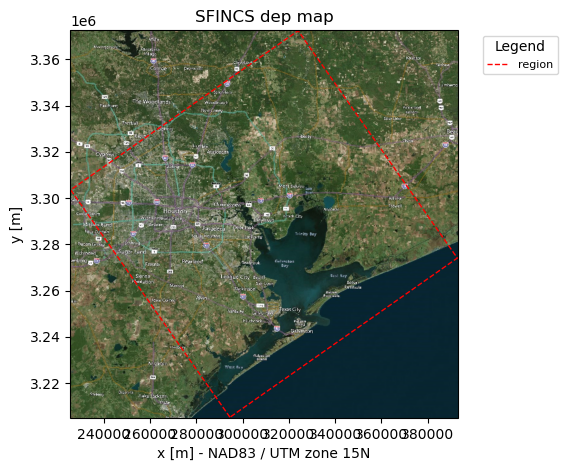

In [3]:
# Specify an input dictionary with the grid settings x0,y0,dx,dy,nmax,mmax,rotation and epsg code.
# create SFINCS model with regular grid and characteristics of the input dictionary:
sf.setup_grid(
    x0=294515.3984,
    y0=3205240.0993,
    dx=200.0,
    dy=200.0,
    nmax=600,
    mmax=600,
    rotation=35,
    epsg=26915, #HydroMT is very sensitive to epsg code. Please use the right epsg code for your study area
)

# sf.region.boundary.plot(figsize=(6,6))
_ = sf.plot_basemap(plot_region=True, bmap="sat", figsize=(5,20), zoomlevel=10)

In [4]:
# Load the necessary DEM and Manning's roughness files

localtiff1 = r"C:/Users/mc77963/OneDrive - The University of Texas at Austin/1 UT Austin Study/Dr Wonhyun SFINCS/SFINCS_Beryl_2/1_All_SFINCS_Run/SFINCS Run 241106/dem3.tif"
localtiff2 = r"C:/Users/mc77963/OneDrive - The University of Texas at Austin/1 UT Austin Study/Dr Wonhyun SFINCS/SFINCS_Beryl_2/1_All_SFINCS_Run/SFINCS Run 241106/crm.tif"
localtiff3 = r"C:/Users/mc77963/OneDrive - The University of Texas at Austin/1 UT Austin Study/Dr Wonhyun SFINCS/SFINCS_Beryl_2/1_All_SFINCS_Run/SFINCS Run 241106/tx_man400_utm.tif"

import xarray as xr

ds_xarray1 = xr.open_dataset(localtiff1, engine="rasterio")
ds_xarray2 = xr.open_dataset(localtiff2, engine="rasterio")
ds_xarray3 = xr.open_dataset(localtiff3, engine="rasterio")

In [5]:
# The second and more elegant option is to use the data_catalog functionalities
# This also adds the data to the data_catalog, so you can use it later on in your workflow without having to specify the path again
# This also allows to keep track which data is actually used in your model (for reproducibility)
# and it has additional options to get the data for partly using bbox, region, zoom_level etc.

ds1 = sf.data_catalog.get_rasterdataset(
    localtiff1,
    variables=["elevtn"],
    geom=sf.region,
    meta={"version": "1"},
)

ds2 = sf.data_catalog.get_rasterdataset(
    localtiff2,
    variables=["elevtn"],
    geom=sf.region,
    meta={"version": "1"},
)

ds3 = sf.data_catalog.get_rasterdataset(
    localtiff3,
    variables=["manning"],
    geom=sf.region,
    meta={"version": "1"},
)

In [6]:
# added to data_catalog
sf.data_catalog["dem3.tif"],sf.data_catalog["crm.tif"],sf.data_catalog["tx_man400_utm.tif"]

(data_type: RasterDataset
 driver: raster
 meta:
   version: '1'
 path: C:/Users/mc77963/OneDrive - The University of Texas at Austin/1 UT Austin Study/Dr
   Wonhyun SFINCS/SFINCS_Beryl_2/1_All_SFINCS_Run/SFINCS Run 241106/dem3.tif
 provider: user,
 data_type: RasterDataset
 driver: raster
 meta:
   version: '1'
 path: C:/Users/mc77963/OneDrive - The University of Texas at Austin/1 UT Austin Study/Dr
   Wonhyun SFINCS/SFINCS_Beryl_2/1_All_SFINCS_Run/SFINCS Run 241106/crm.tif
 provider: user,
 data_type: RasterDataset
 driver: raster
 meta:
   version: '1'
 path: C:/Users/mc77963/OneDrive - The University of Texas at Austin/1 UT Austin Study/Dr
   Wonhyun SFINCS/SFINCS_Beryl_2/1_All_SFINCS_Run/SFINCS Run 241106/tx_man400_utm.tif
 provider: user)

In [7]:
sf.data_catalog.get_rasterdataset

<bound method DataCatalog.get_rasterdataset of                    provider                             version  \
name                                                              
chelsa                 None                                 1.2   
chirps_global          None                                v2.0   
corine                 None                         v.2020_20u1   
dtu10mdt               None                                2010   
dtu10mdt_egm96         None                                2010   
eobs                   None                               22.0e   
eobs_orography         None                               22.0e   
era5                   None  ERA5 daily data on pressure levels   
era5_hourly            None                                None   
era5_daily_zarr        None                                None   
era5_hourly_zarr       None                                None   
era5_orography         None                                None   
gadm_level1    

In [8]:
da_dep1 = sf.data_catalog.get_rasterdataset(
    "dem3.tif", variables=["elevtn"], geom=sf.region, buffer=5
)

da_dep2 = sf.data_catalog.get_rasterdataset(
    "crm.tif", variables=["elevtn"], geom=sf.region, buffer=5
)

In [9]:
datasets_dep = [
    {"da": da_dep1, "zmin": -21}, #check the minimum value of your dem3.tif file in arcgis
    {"da": da_dep2, "offset": 0},
]

In [10]:
dep = sf.setup_dep(datasets_dep=datasets_dep)

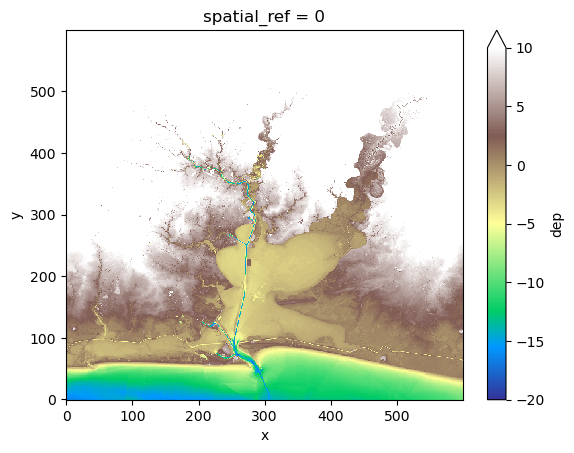

In [11]:
sf.grid["dep"].plot.imshow(vmin=-20, vmax=10, cmap="terrain")

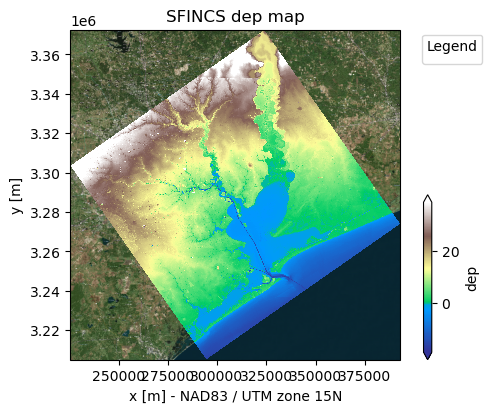

In [12]:
_ = sf.plot_basemap(variable="dep", bmap="sat", zoomlevel=12)

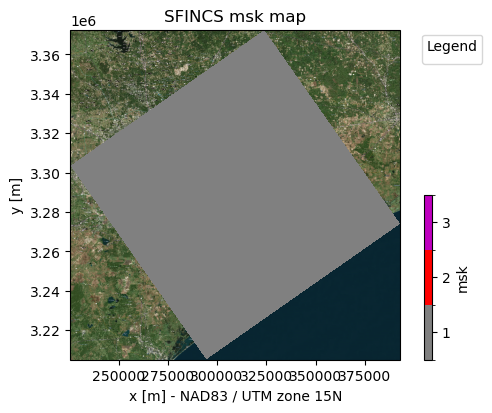

In [13]:
# Choosing how to choose you active cells can be based on multiple criteria, here we only specify a minimum elevation
# 1 = Active / 2 = Water Level / 3 = outflow

sf.setup_mask_active(zmin=-21, reset_mask=True)

# Make a plot of the mask file
_ = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)

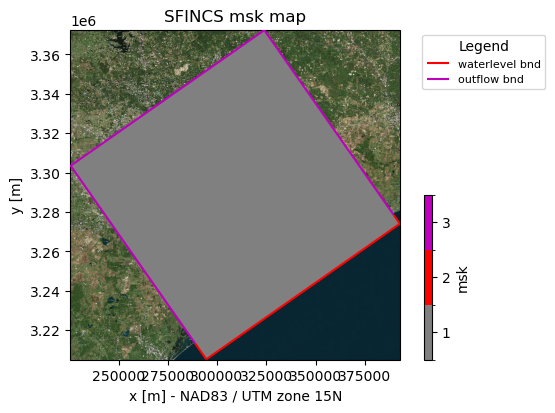

In [14]:
# Here we add water level cells along the coastal boundary, for cells up to an elevation of -5 meters
sf.setup_mask_bounds(btype="waterlevel", zmax=-5, reset_bounds=True)

# Here we add outflow cells
sf.setup_mask_bounds(btype="outflow", zmax=50, reset_bounds=True)

# Make a plot of the mask file
fig, ax = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)
# plot the shapefile given by the user as dashed line

In [15]:
# --> this is used in making subgrid tables

da_manning = sf.data_catalog.get_rasterdataset(
    "tx_man400_utm.tif", variables=["manning"], geom=sf.region, buffer=5
)

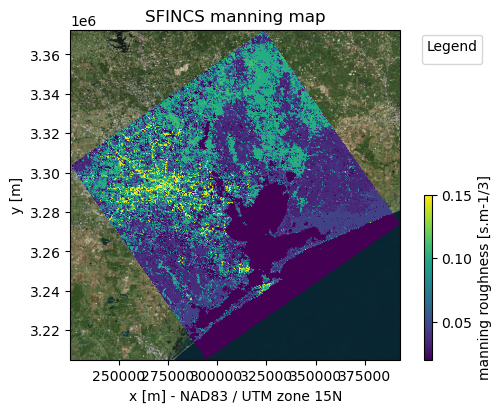

In [16]:
# use the river manning raster in combination with vito land to derive the manning roughness file
# NOTE that we can combine in-memory data with data from the data catalog
datasets_rgh = [{"manning": da_manning}]

sf.setup_manning_roughness(
    datasets_rgh=datasets_rgh,    
)
_ = sf.plot_basemap(variable="manning", plot_bounds=False, bmap="sat", zoomlevel=12)

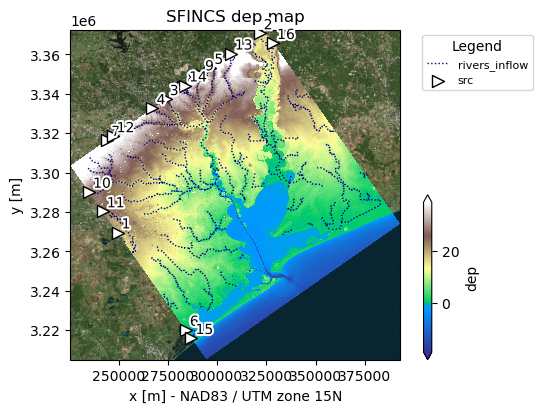

In [17]:
# replace your own study area's MERIT Hydro files in the artifact data folder before running this line of code
# derive river from hydrography data based on a minimum river length (river_len)
# and minimum upstream area (river_upa)

sf.setup_river_inflow(
    hydrography="merit_hydro", river_len=1000, river_upa=50, keep_rivers_geom=True
)

# Make a plot of model
# note the src points and derived river network
fig, ax = sf.plot_basemap(variable="dep", plot_bounds=False, bmap="sat", zoomlevel=12)

In [18]:
gdf_riv = sf.geoms["rivers_inflow"].copy()
gdf_riv

,geometry,idx,idx_ds,pit,uparea,seglen,rivdst,rivlen
235,"LINESTRING (286977.998 3216004.623, 287023.548...",3709736,3574324,False,54.614658,3171.149312,7640.513279,7640.513279
285,"LINESTRING (288770.305 3218332.146, 288851.443...",3574324,3574364,False,764.044312,4469.363968,4469.363968,11977.692105
207,"LINESTRING (284075.114 3220150.371, 284097.299...",3512774,3574324,False,539.297424,7508.328137,11977.692105,11977.692105
287,"LINESTRING (291160.016 3233625.748, 291158.325...",3222928,3267410,False,50.283997,4008.279124,4008.279124,4008.279124
248,"LINESTRING (296671.297 3238145.759, 296752.291...",3117145,3301306,False,345.173523,13530.688933,13530.688933,66001.259314
...,...,...,...,...,...,...,...,...
58,"LINESTRING (328904.439 3353092.414, 328824.288...",471271,464907,False,52.422733,1387.357021,113928.063235,113928.063235
41,"LINESTRING (326661.552 3363290.759, 326660.08 ...",238371,464907,False,44198.574219,18620.335311,131161.041524,143332.328583
31,"LINESTRING (318527.507 3365456.107, 318607.571...",191695,475441,False,51.052486,27658.602169,140415.587021,140415.587021
33,"LINESTRING (328382.528 3365758.021, 328381.07 ...",181233,238371,False,51.975582,6913.490351,138074.531875,138074.531875


In [19]:
localtiff4 = r"C:/Users/mc77963/.hydromt_data/artifact_data/v0.0.9/data.tar/merit_hydro/rivwth.tif"
ds_xarray4 = xr.open_dataset(localtiff4, engine="rasterio")

In [20]:
ds_xarray4

<xarray.Dataset> Size: 576MB
Dimensions:      (band: 1, x: 12000, y: 12000)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 96kB -100.0 -100.0 -100.0 ... -90.0 -90.0 -90.0
  * y            (y) float64 96kB 35.0 35.0 35.0 35.0 ... 25.0 25.0 25.0 25.0
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float32 576MB ...

In [21]:
# --> this is used when the making subgrid tables (step 8)

# use the derived rivers to burn these into the model subgrid
# note that the width and depth are arbitrary here

gdf_riv = sf.geoms["rivers_inflow"].copy()
gdf_riv["rivwth"] = ds_xarray4
gdf_riv["rivdph"] = 1.5  # depth [m]
gdf_riv["manning"] = 0.03  # manning coefficient [s.m-1/3]
gdf_riv[["geometry", "rivwth", "rivdph", "manning"]]

# prepare the river dataset for the subgrid
# instead of using the derived rivers, you could also use an aribitrary shapefile with centerlines
# Other options include to add a river mask shapefile rather than a river width attribute
# Note that the width is either specified on the river centerline or with a river mask
# Also the river bed level (rivbed) can be specified instead of the river depth (rivdph).

datasets_riv = [{"centerlines": gdf_riv}]

In [23]:
# Every single grid cell of the flux grid of the size inp.dx by inp.dy is defined into subgrid pixels (default is 20, nr_subgrid_pixels = 20).
# For every subgrid pixel the topobathy data is loaded, ideally this consists also of high-resolution DEM datasets that you specify as user.

sf.setup_subgrid(
    datasets_dep=datasets_dep,
    datasets_rgh=datasets_rgh,
    datasets_riv=datasets_riv,
    nr_subgrid_pixels=20,
    write_dep_tif=True,
    write_man_tif=False,
)

# NOTE: we turned on that the merged topobathy of the different (high-res) datasets is written to a geotiff

# NOTE: if you have a very large domain with 100,000s to millions of cells, and very high-resolution datasets (e.g. 1 m), this step might take minutes to hours!!!
#       But good news; when finished succesfully, you can very quickly run very accurate SFINCS simulations!
#       The whole point of the subgrid functionality of SFINCS is that by derived subgrid tables based on high res elevation data,
#       you either have more accurate results or run on a coarser grid resolution (= much faster) or both

In [24]:
sf.subgrid

<xarray.Dataset> Size: 122MB
Dimensions:      (y: 600, x: 600, levels: 10)
Coordinates:
    yc           (y, x) float64 3MB 3.205e+06 3.205e+06 ... 3.372e+06 3.372e+06
    xc           (y, x) float64 3MB 2.945e+05 2.947e+05 ... 3.238e+05 3.24e+05
    spatial_ref  int32 4B 0
  * levels       (levels) int32 40B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: y, x
Data variables: (12/18)
    z_zmin       (y, x) float32 1MB -16.42 -16.4 -16.36 ... 20.0 21.0 22.0
    z_zmax       (y, x) float32 1MB -16.25 -16.2 -16.2 ... 21.87 22.66 24.44
    z_volmax     (y, x) float32 1MB 3.985e+03 5.047e+03 ... 3.112e+04 5.721e+04
    u_zmin       (y, x) float32 1MB -16.39 -16.35 -16.29 ... 21.01 22.01 23.35
    u_zmax       (y, x) float32 1MB -16.29 -16.2 -16.2 ... 22.25 23.55 25.33
    u_ffit       (y, x) float32 1MB 35.51 40.87 63.92 ... 4.087 2.687 2.054
    ...           ...
    u_havg       (levels, y, x) float32 14MB 0.004425 0.0003361 ... 1.235 1.44
    u_nrep       (levels, y, x) float32 14MB 0.01113 0.0009312 ... 0.07584
    u_pwet       (levels, y, x) float32 14MB 0.485 0.1 0.1 0.115 ... 1.0 1.0 1.0
    v_havg       (levels, y, x) float32 14MB 0.0006606 8.398e-05 ... 1.337
    v_nrep       (levels, y, x) float32 14MB 0.001856 0.0009349 ... 0.07836
    v_pwet       (levels, y, x) float32 14MB 0.14 0.015 0.095 ... 1.0 1.0 1.0
Attributes:
    _FillValue:  nan

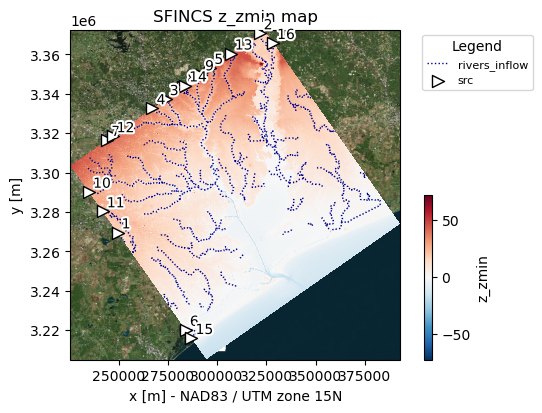

In [25]:
# we can plot the 2D subgrid variables
_ = sf.plot_basemap(
    variable="subgrid.z_zmin", plot_bounds=False, bmap="sat", zoomlevel=12
)

In [26]:
# independent from subgrid files
# curve number infiltration based on global CN dataset
sf.setup_cn_infiltration("gcn250", antecedent_moisture="avg")

# check all variables in the sf.grid dataset
sf.grid.data_vars.keys()

KeysView(Data variables:
    dep      (y, x) float32 1MB -16.34 -16.33 -16.25 ... 21.03 21.97 23.12
    msk      (y, x) uint8 360kB 2 2 2 2 2 2 2 2 2 2 2 ... 3 3 3 3 3 3 3 3 3 3 3
    manning  (y, x) float64 3MB 0.02 0.02 0.02 0.02 ... 0.09234 0.09234 0.08426
    scs      (y, x) float64 3MB dask.array<chunksize=(600, 600), meta=np.ndarray>)

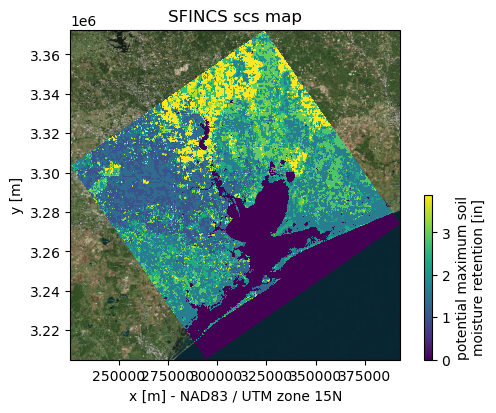

In [27]:
_ = sf.plot_basemap(variable="scs", plot_bounds=False, plot_geoms=False, bmap="sat", zoomlevel=12)

In [28]:
# Change period of model simulation time, specified in yyyymmdd HHMMSS --> simulation time here is 24 hours
sf.setup_config(
    **{
        "tref": "20240701 000000",
        "tstart": "20240701 000000",
        "tstop": "20240712 000000",
    }
)

print(sf.config)

{'mmax': 600, 'nmax': 600, 'dx': 200.0, 'dy': 200.0, 'x0': 294515.3984, 'y0': 3205240.0993, 'rotation': 35, 'latitude': 0.0, 'tref': '20240701 000000', 'tstart': '20240701 000000', 'tstop': '20240712 000000', 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'zsini': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 1, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 26915, 'mskfile': 'sfincs.msk', 'indexfile': 'sfincs.ind', 'sbgfile': 'sfincs_subgrid.nc', 'scsfile': 'sfincs.scs'}


In [29]:
# preprocess the rainfall file downloaded from the ERA5 before running this line of code
# place the preprocessed rainfall file from ERA5 to the artifact data folder and rename it as "era5_hourly"
# hourly rainfall rates of ECMWF' ERA5 data for the specific area and period have been made available for this period in the artefact data
sf.setup_precip_forcing_from_grid(precip="era5_hourly", aggregate=False)

# NOTE: the precipitation forcing data is now stored in the sf.forcing dictionary
sf.forcing.keys()

dict_keys(['dis', 'precip_2d'])

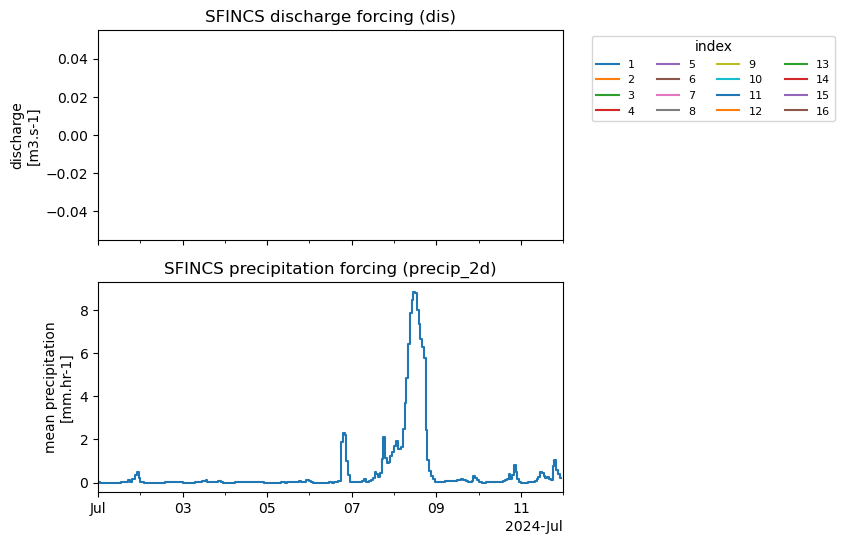

In [30]:
# Plot combined forcing time-series:
_ = sf.plot_forcing()

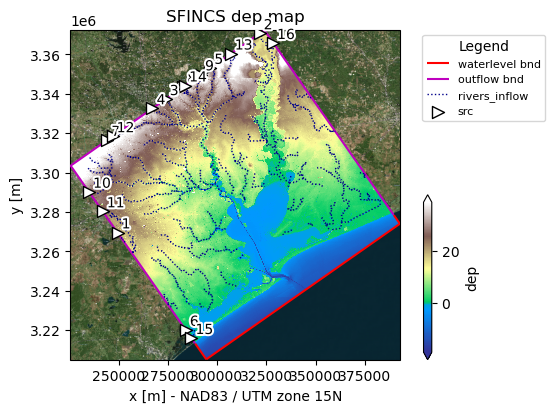

In [31]:
# Use predefined plotting function 'plot_basemap' to show your full SFINCS model setup
_ = sf.plot_basemap(fn_out="basemap.png" ,bmap="sat", zoomlevel=12)

In [32]:
sf.write()  # write all

In [33]:
# Show created files in folder:
dir_list = os.listdir(sf.root)
print(dir_list)

['figs', 'gis', 'hydromt.log', 'hydromt_data.yml', 'precip_2d.nc', 'sfincs.dis', 'sfincs.ind', 'sfincs.inp', 'sfincs.msk', 'sfincs.scs', 'sfincs.src', 'sfincs_subgrid.nc', 'subgrid']
